In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import obspy
from scipy.interpolate import interp1d
from obspy.imaging.spectrogram import spectrogram
from obspy.signal.filter import integer_decimation
from spectrogram_modify import spectrogram_modify

MicSigV1=pd.read_json('/Users/tanx//mtetna/MicSigV1/MicSigV1_jsn/MicSigV1/MicSigV1_v1_1.json')

In [2]:
MicSigV1

,Network,Station,SampleRate,Component,Year,Month,Type,Duration,StartPoint,EndPoint,Data
0,EC,VC1,100,SHZ,2012,1,VT,23,1001,3301,"[23.355529956093186, -26.21249638722304, 7.478..."
1,EC,VC1,100,SHZ,2012,1,LP,47,1001,5701,"[-9.39456702711197, 5.797439374378022, -23.901..."
2,EC,VC1,100,SHZ,2012,1,LP,56,1001,6601,"[-3.915706523024276, 0.420532668769778, -21.37..."
3,EC,VC1,100,SHZ,2012,1,VT,49,1001,5901,"[-2.5686254658527723, 23.91770870655175, -10.7..."
4,EC,VC1,100,SHZ,2012,1,VT,31,1001,4101,"[55.05791051352128, 41.33929940327658, -19.424..."
...,...,...,...,...,...,...,...,...,...,...,...
1182,EC,BREF,50,BHZ,2019,3,LP,23,501,1651,"[-5.580699845211788, -3.212906366210063, 34.67..."
1183,EC,BREF,50,BHZ,2019,3,LP,28,501,1901,"[56.598142787725685, 35.85003980602864, 7.8977..."
1184,EC,BREF,50,BHZ,2019,3,LP,46,501,2801,"[2.387041324869946, -64.67153614317736, -62.47..."
1185,EC,BREF,50,BHZ,2019,3,LP,32,501,2101,"[-22.842053996805145, -27.189113048671395, -27..."


In [3]:
REGIONAL = MicSigV1[MicSigV1.Type=='REGIONAL']
HB = MicSigV1[MicSigV1.Type=='HB']
ICEQUAKE = MicSigV1[MicSigV1.Type=='ICEQUAKE']
VT = MicSigV1[MicSigV1.Type=='VT']
LP = MicSigV1[MicSigV1.Type=='LP']
# MicSigV1.Type['REGIONAL']
# plt_and_save(ICEQUAKE,879,False)

In [4]:
def plt_and_save(df, idx, save=True, Str=None, per_lap=0.5, start_point:int = 0, end_point=256):
    Fs = df.SampleRate[idx]
    Station = df.Station[idx]
    Label = df.Type[idx]
    signal = df.Data[idx]
    signal_type = df.Type[idx]
    sample_rate = df.SampleRate[idx]
    if sample_rate == 100: 
        signal = integer_decimation(signal, 2)
    # print(len(signal))
    if len(signal[start_point:]) < 4100:
        signal = np.pad(signal[start_point:],(0,4100-len(signal[start_point:])),'edge')
    else:
        signal = signal[start_point:4100+start_point]

    # print(sample_rate)
    t = 1/Fs*np.linspace(0,len(signal)-1,len(signal))

    # plt.plot(t,signal)
    fig, ax = plt.subplots(figsize = (4,3),dpi=200)
    ax.set_xticks([])
    ax.set_yticks([])
    start_point = np.random.rand(1)*start_point
    ax, spec, _ = spectrogram_modify(np.array(signal), wlen=1.6, samp_rate=50, show=False ,per_lap=0, fmt='jpg', axes=ax)
    path = '/Users/tanx/mtetna/MicSigV1/MicSigV1_jsn/MicSigV1/spec_python_aug2/'+signal_type+'/'+signal_type+str(idx)+Str+'.npy'
    spec_mean = np.mean(spec)
    spec_var = np.std(spec)
    spec = (spec-spec_mean)/spec_var
    if save:
        if spec.shape[-1]>end_point:
            np.save(path, spec[:,:int(end_point)])
        else:
            np.save(path, spec)
    return spec, signal
    # plt.savefig(path)
    # print(spec.shape)
    # print(path)


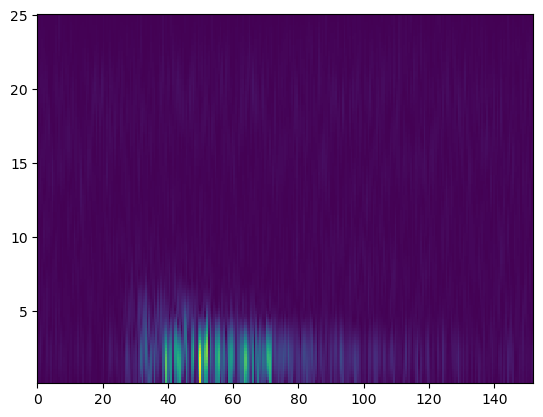

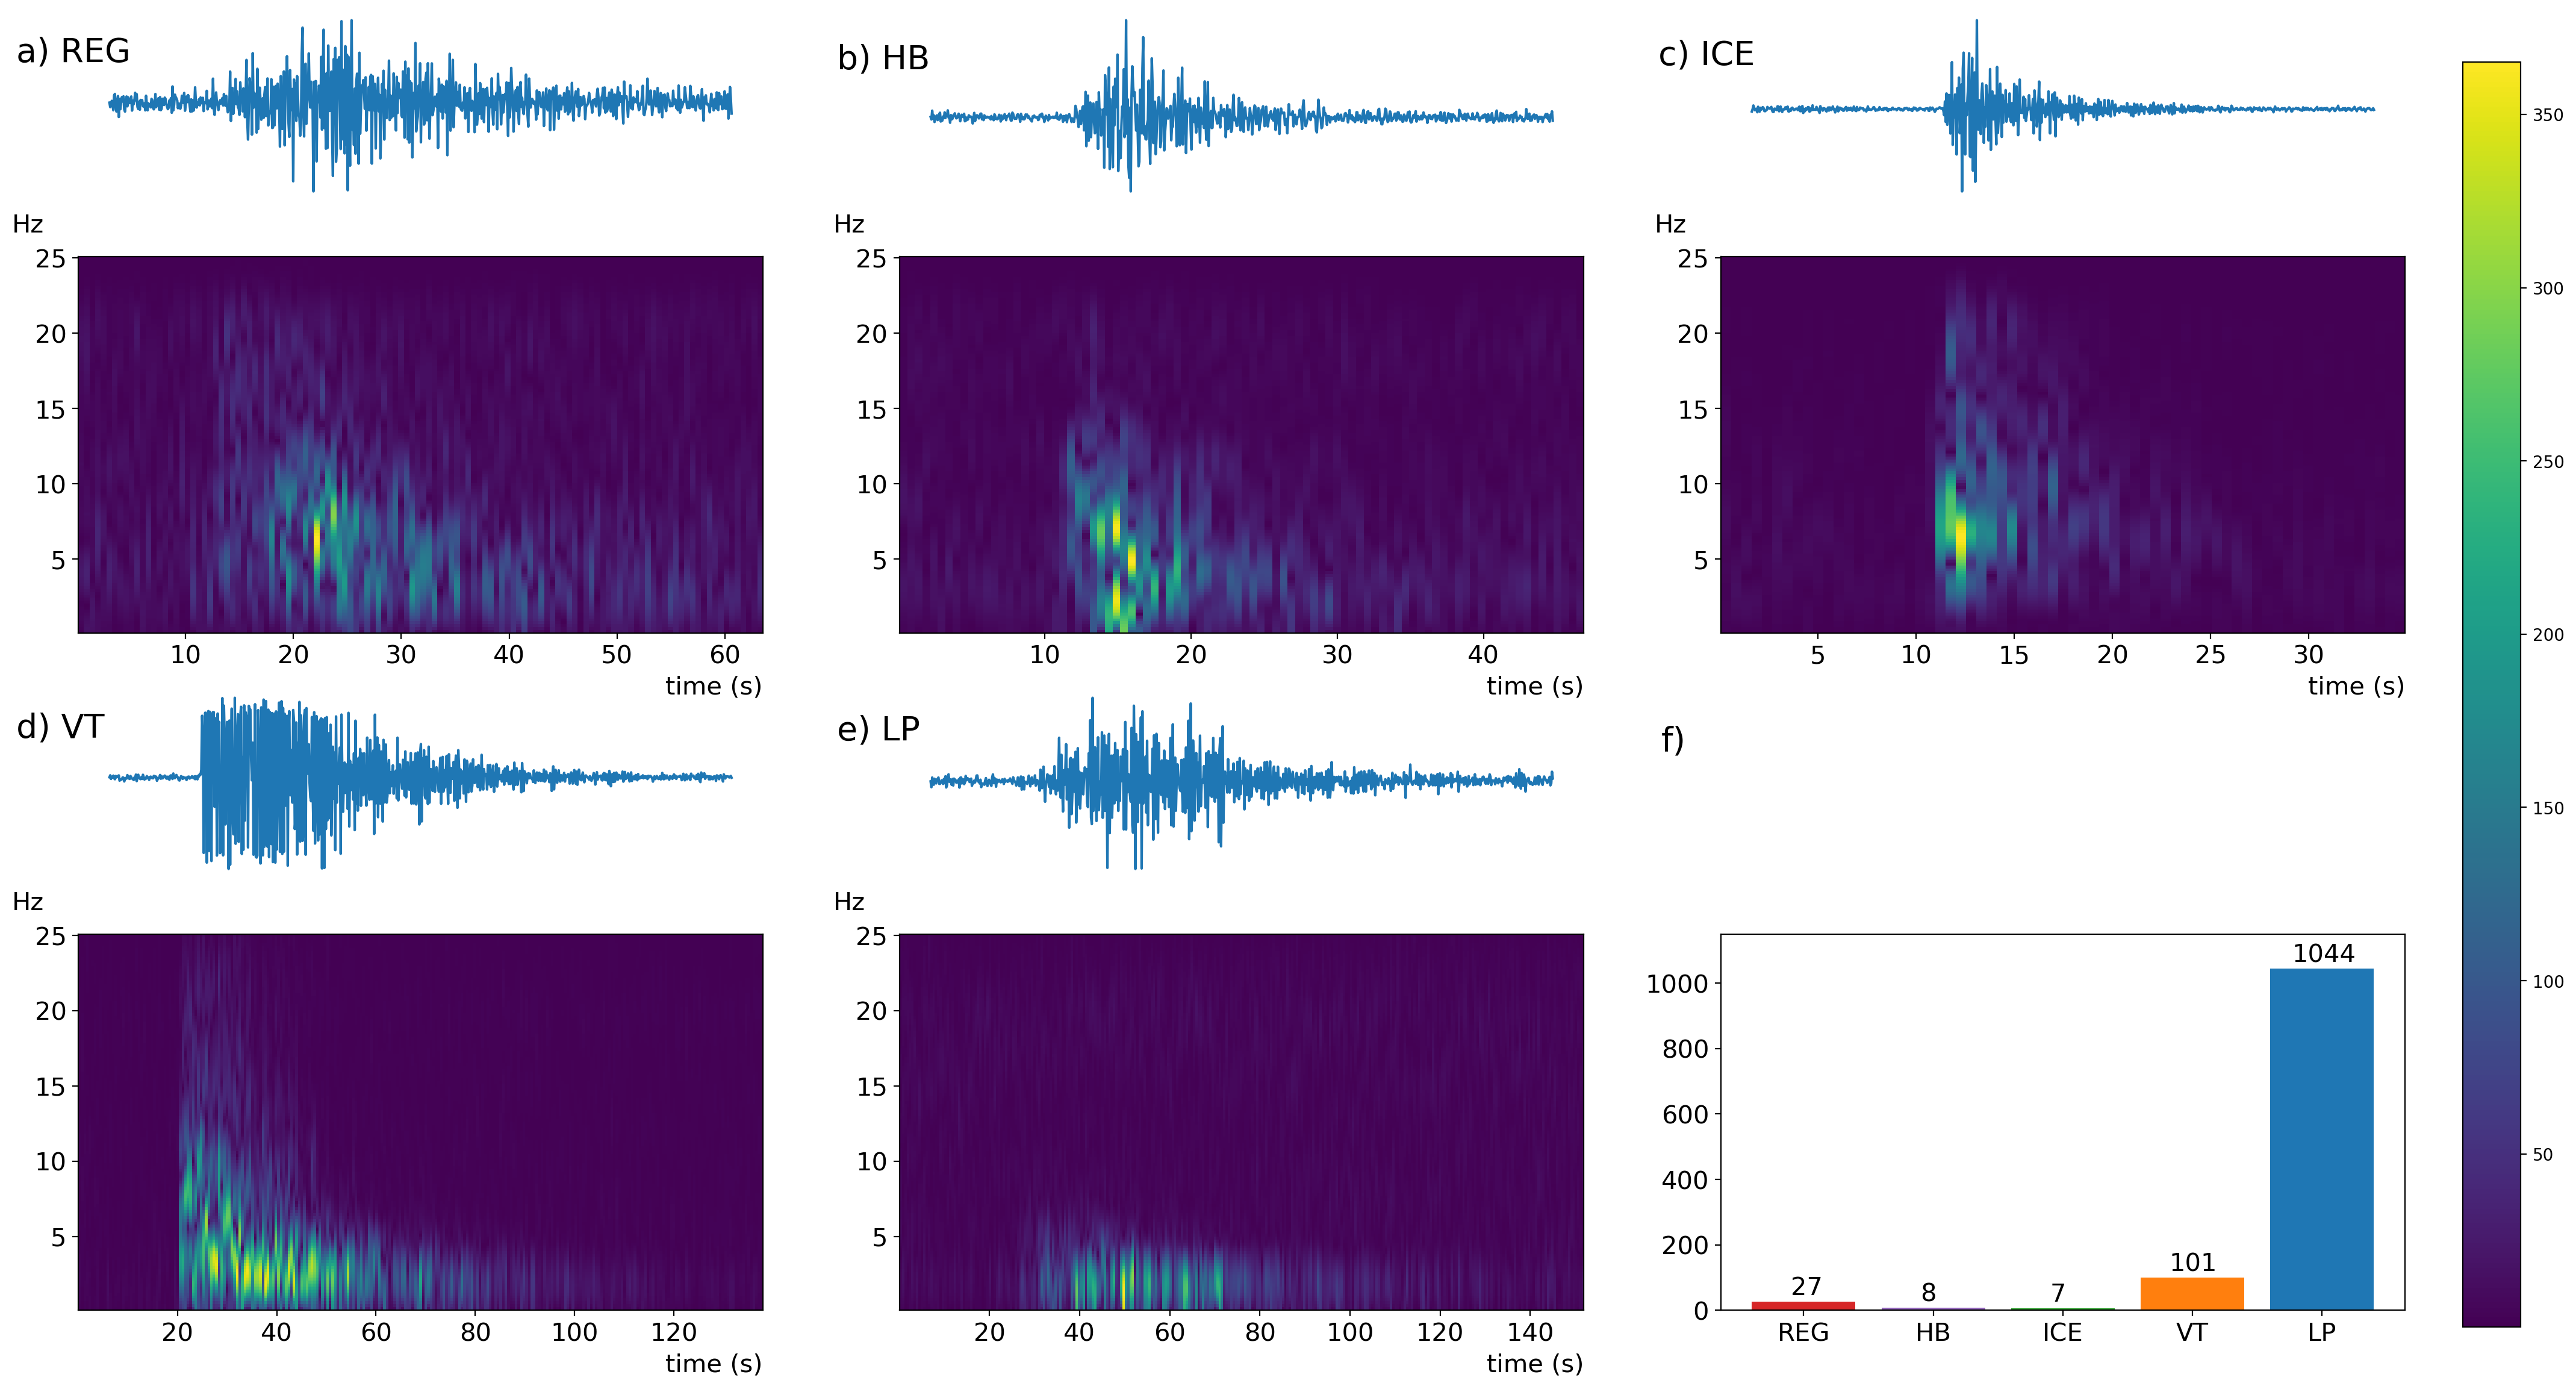

In [5]:
f, ax = plt.subplots()
text = ['a) REG', 'b) HB', 'c) ICE', 'd) VT', 'e) LP']
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(24, 14), dpi=200, gridspec_kw={'height_ratios': [1, 2, 1, 2]})
axs = axs.flat
for i, item in enumerate([REGIONAL, HB, ICEQUAKE, VT, LP]):
    j = 3*math.floor(i/3) + i
    sig = np.array(item.Data[item.index[1]])
    x = np.linspace(0, len(sig)-1, len(sig), endpoint=True)
    new_x = np.linspace(0, len(sig)-1, num=800, endpoint=True)
    func = interp1d(x, sig, kind='cubic')
    new_sig = func(new_x)
    axs[j].plot(new_sig/max(new_sig))
    _,spec,extent = spectrogram_modify(sig, samp_rate=50, per_lap=0.2, fmt='jpg',axes =ax)
    axs[j].axis('off')
    axs[j].get_yaxis().set_visible(False)
    axs[j].text(x=-120,y=0.5,s=text[i],fontsize=20)
    im = axs[j+3].imshow(spec, extent =extent,interpolation='nearest', aspect='auto')
    axs[j+3].set_ylabel('Hz',fontsize=15,rotation=0, x=1600, y=1.05)
    axs[j+3].set_xlabel('time (s)',loc='right',fontsize=15)
    axs[j+3].tick_params(axis='both', which='major', labelsize=15)
    # axs[j+3].text(x=-4,y=27,s='Hz',fontsize=15)

fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])
fig.colorbar(im, orientation='vertical',cax=cbar_ax)

axs[8].remove()
events = ['REG', 'HB', 'ICE', 'VT', 'LP']
bar_colors = ['tab:red', 'tab:purple', 'tab:green', 'tab:orange', 'tab:blue']
num = [27,8,7,101,1044]
axs[11].bar(events,num,color=bar_colors)
axs[11].tick_params(axis='both', which='major', labelsize=15)
axs[11].set_ylim([0,1150])
for k in range(3):
    axs[11].text(x=k-0.1,y=num[k]+20,s=str(num[k]),fontsize=15)
axs[11].text(x=3-0.18,y=num[3]+20,s=str(num[3]),fontsize=15)
axs[11].text(x=4-0.23,y=num[4]+20,s=str(num[4]),fontsize=15)
axs[11].text(x=-1.1,y=1710,s='f)',fontsize=20)
# axs[11].set_title('e') 
# axs[11].set_xticks(xticks_pos, labels,  ha='right', rotation=55, fontsize=20)
    # axs[11].legend(title='Fruit color')
plt.savefig('spectro_gram')

In [7]:
labels = []
sigs = []
specs = []

for idx in range(len(MicSigV1)):
# plt_and_save(idx, save=True)
    string=MicSigV1.Type[idx]
    if string=='ICEQUAKE':
        label=1
    elif string=='HB':
        label=2
    elif string=='REGIONAL':
        label=3
        for k in range(120):
            labels.append(label)
            spec, sig = plt_and_save(MicSigV1, idx, save=False, Str='r0', per_lap=0.8, 
                                     start_point = int(abs(np.random.randn(1))*256), end_point=256)
            specs.append(spec)
            sigs.append(sig)
    elif string=='VT':
        label=4
        for k in range(40):
            labels.append(label)
            spec, sig = plt_and_save(MicSigV1, idx, save=False, Str='r0', per_lap=0.8, 
                                     start_point = int(abs(np.random.randn(1))*256), end_point=256)
            specs.append(spec)
            sigs.append(sig)
    elif string=='LP':
        label=5
        for k in range(4):
            labels.append(label)
            spec, sig = plt_and_save(MicSigV1, idx, save=False, Str='r0', per_lap=0.8, 
                                     start_point = int(abs(np.random.randn(1))*256), end_point=256)
            specs.append(spec)
            sigs.append(sig)


array_specs = np.array(specs)[:,::8,:]
array_sigs = np.array(sigs)
array_labels = np.array(labels)
print(array_specs.shape)

np.save('spec4.npy',array_specs)
np.save('waveform4.npy',array_sigs)
np.save('label4.npy',array_labels)

In [8]:
test_labels = []
test_sigs = []
test_specs = []

for i in range(10):
    for idx in range(len(MicSigV1)):
        # plt_and_save(idx, save=True)
        string=MicSigV1.Type[idx]
        if string=='ICEQUAKE':
            label=1
        elif string=='HB':
            label=2
        elif string=='REGIONAL':
            label=3
        elif string=='VT':
            label=4
        elif string=='LP':
            label=5
        test_labels.append(label)
        spec, sig = plt_and_save(MicSigV1, idx, save=True, Str='r0', per_lap=0.8, 
                                 start_point = int(abs(np.random.randn(1))*256), end_point=256)
        test_specs.append(spec)
        test_sigs.append(sig)
        
test_array_specs = np.array(test_specs)[:,::8,:]
test_array_sigs = np.array(test_sigs)
test_array_labels = np.array(test_labels)

np.save('test_spec.npy',test_array_specs)
np.save('test_waveform.npy',test_array_sigs)
np.save('test_label.npy',test_array_labels)